# Задача Б: поиск фейковых отзывов

Отзывы на Wildberries — вид обратной связи, которую можно оставить только после заказа товара. Отзывы отображаются в карточке товара (см. рис.) и отражаются в виде рейтинга товара в звездах с текстовым комментарием.

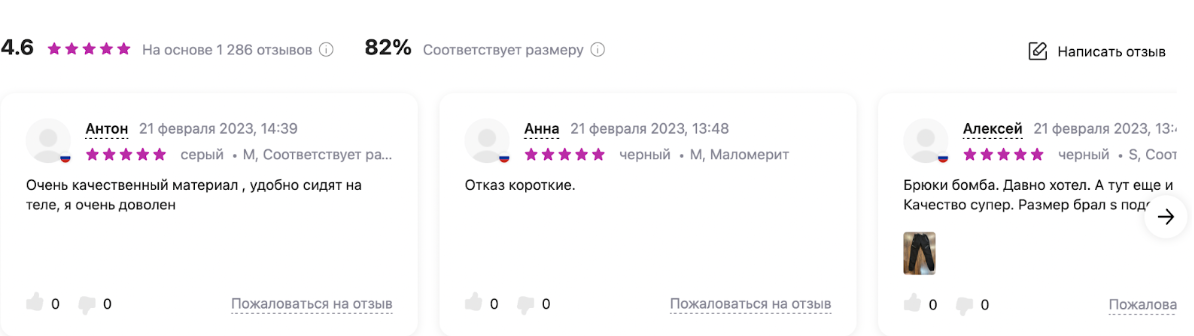
#### Задача
Необходимо разработать механизм, позволяющий определить фейковые отзывы. Фейковый отзыв — проплаченный, нечестно мотивированный отзыв с целью повлиять на рейтинг товара. 
Существует два вида таких отзывов: 
положительный отзыв написан для поставщика, который заказал себе этот отзыв; 
отрицательный отзыв написан для другого поставщика с целью снизить рейтинг товара.
#### Данные
Предоставляем список размеченных отзывов, со всей необходимой мета-информацией формате csv (пользователь, текст отзыва, оценка, является ли фейком)
#### Результат
Итогом работы должен стать набор скриптов, который позволяет по полученному на входе отзыву получить ответ, является отзыв фейковым, а также сформированная выдача для тестовых отзывов.


## <u>Этап 1.</u> Проработка и формализация задачи, определение таргета

Задача состоит в том, чтобы определить является отзыв фейковым или нет. Это задача бинарной классификации, в качестве объектов принимаются отзывы, каждый из которых представлен множеством количественных признаков `f1`, `f2`,  ... `f8`. <b>Таргетом</b> в данной задаче является индикатор Y = {1 - если фейк, 0 - иначе}.

Таким образом, <b>результатом решения</b> должна стать модель, которая по входным данным: `f1`, `f2`, ... `f8` определяет является отзыв фейковым или нет.

## <u>Этап 2.</u> Первичный анализ данных, очищение данных

Импортируем все необходимые модули, считаем данные и посмотрим на первые пять строк.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('wb_school_task_2.csv.gzip', compression='gzip')

In [4]:
data.head(5)

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.0,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.0,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.0,6,4,5.000000,26,33,0


Уберем ненужные для нас столбцы `id1`, `id2`, `id3`, `text` и запишем эту таблицу в новую переменную <b><i>df</i></b>.

In [5]:
df = data.iloc[:, 4:]
df.head(5)

,f1,f2,f3,f4,f5,f6,f7,f8,label
0,1,1,1.0,11,13,4.272727,18,36,0
1,10,6,2.7,46,4,4.434783,90,109,1
2,4,4,4.0,14,0,4.500000,4,6,0
3,6,6,5.0,374,30,4.772727,14,15,1
4,19,18,5.0,6,4,5.000000,26,33,0


Посмотрим на сводную статистику по данным и на типы каждого из столбцов.

In [6]:
display(df.describe())
df.info()

,f1,f2,f3,f4,f5,f6,f7,f8,label
count,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000
mean,19.409862,16.216459,4.232658,808.603586,216.628562,4.453445,48.155620,94.356708,0.264169
std,35.746560,26.070112,1.179999,2509.350075,802.154201,0.619495,67.107753,329.525613,0.440960
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,2.000000,2.000000,4.076923,26.000000,6.000000,4.331071,8.000000,13.000000,0.000000
50%,8.000000,7.000000,4.764706,116.000000,26.000000,4.617978,30.000000,45.000000,0.000000
75%,23.000000,20.000000,5.000000,493.000000,110.000000,4.809556,65.000000,107.000000,1.000000
max,638.000000,550.000000,5.000000,35375.000000,15683.000000,5.000000,1058.000000,9243.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      3123 non-null   int64  
 1   f2      3123 non-null   int64  
 2   f3      3123 non-null   float64
 3   f4      3123 non-null   int64  
 4   f5      3123 non-null   int64  
 5   f6      3123 non-null   float64
 6   f7      3123 non-null   int64  
 7   f8      3123 non-null   int64  
 8   label   3123 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 219.7 KB


Как видим, все данные приведены в подходящий формат.

<b>Проверим есть ли пропуски в данных.</b>

In [7]:
df.isnull().sum()

f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
label    0
dtype: int64

Пропусков нет

Посмотрим на соотношение фейковых и непроплаченных отзывов.

In [8]:
fakes_count = df[df['label'] == 1].shape[0]
print('Количество фейковых отзывов: ', fakes_count)
print('Количество реальных отзывов: ', df.shape[0] - fakes_count)

Количество фейковых отзывов:  825
Количество реальных отзывов:  2298


Посмотрим на матрицу корреляции через тепловую карту. 

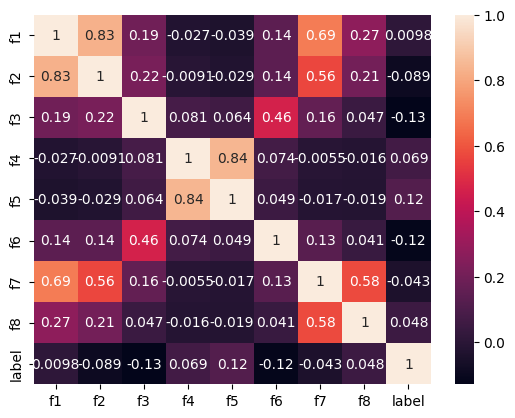

In [9]:
corr = df.corr()
sns.heatmap(corr, annot=True);

Можно заметить 
 * Высокую положительную корреляцию между признаками: `f1` и `f2`, `f4` и `f5`;
 * Среднюю положительную корреляцию между признаками: `f1` и `f7`, `f2` и `f7`, `f7` и `f8`;

In [10]:
df = df.drop(df[(df['label'] == 0) & (df['f8'] > 6000)].index)
df = df.drop(df[df['f7'] > 900].index)

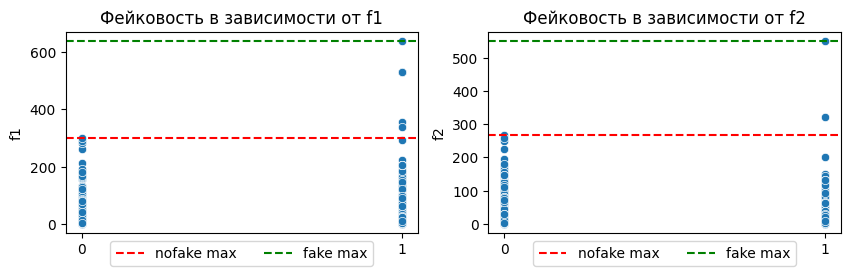

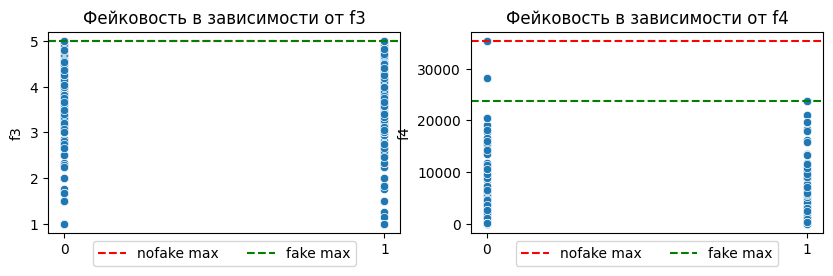

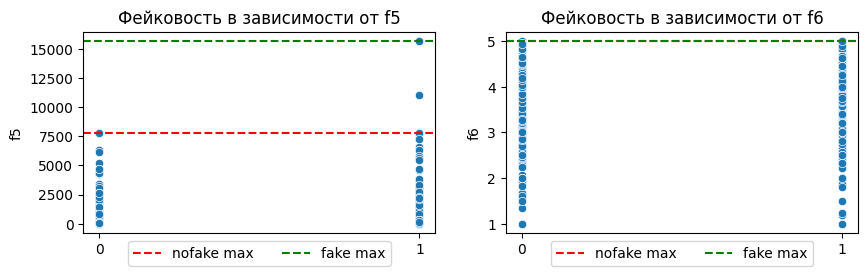

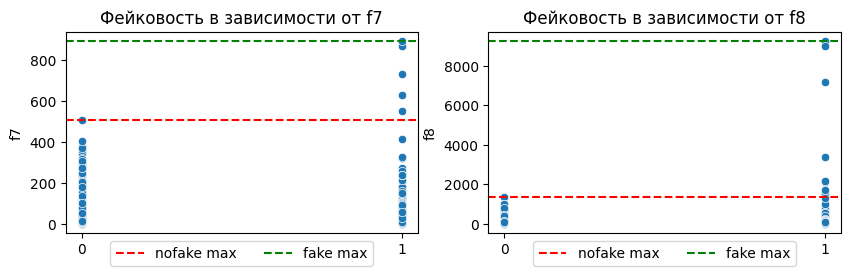

In [11]:
for i in range(1, 9, 2):
    plt.figure(figsize=(10, 12))
    
    plt.subplot(4, 2, i)
    plt.title(f'Фейковость в зависимости от f{i}')
    sns.scatterplot(y=df[f'f{i}'], x=df['label'])
    plt.axhline(y=df[df['label'] == 0][f'f{i}'].max(), color='red', linestyle='--', label='nofake max')
    plt.axhline(y=df[df['label'] == 1][f'f{i}'].max(), color='green', linestyle='--', label='fake max')
    plt.xticks([0, 1])
    plt.xlabel(None)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    
    plt.subplot(4, 2, i+1)
    plt.title(f'Фейковость в зависимости от f{i+1}')
    sns.scatterplot(y=df[f'f{i+1}'], x=df['label'])
    plt.axhline(y=df[df['label'] == 0][f'f{i+1}'].max(), color='red', linestyle='--', label='nofake max')
    plt.axhline(y=df[df['label'] == 1][f'f{i+1}'].max(), color='green', linestyle='--', label='fake max')
    plt.xticks([0, 1])
    plt.xlabel(None)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    
    plt.show()

Избавимся от значений между красной и зеленой чертами. Это выбросы или аномалии. Для них определим правила, чтобы позже собрать ансамбль из дерева решений и моделью.

In [12]:
df = df.drop(df[df['f1'] > df[df['label'] == 0]['f1'].max()].index)
df = df.drop(df[df['f2'] > df[df['label'] == 0]['f2'].max()].index)
df = df.drop(df[df['f4'] > df[df['label'] == 1]['f4'].max()].index)
df = df.drop(df[df['f5'] > df[df['label'] == 0]['f5'].max()].index)
df = df.drop(df[df['f7'] > df[df['label'] == 0]['f7'].max()].index)
df = df.drop(df[df['f8'] > df[df['label'] == 0]['f8'].max()].index)

<b>Посмотрим есть ли выбросы среди признаков f1..f8.</b> 

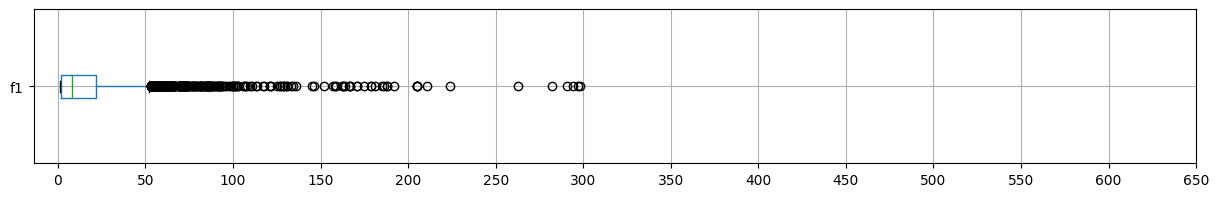

In [13]:
df.boxplot('f1', vert=False, figsize=(15, 2))
plt.xticks(np.arange(0, 700, 50))
plt.show();

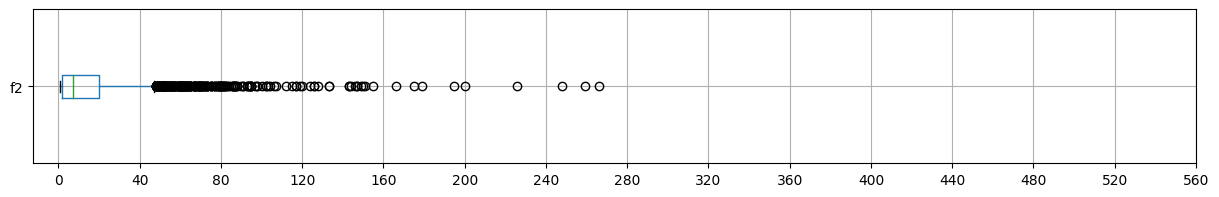

In [14]:
df.boxplot('f2', vert=False, figsize=(15, 2))
plt.xticks(np.arange(0, 600, 40))
plt.show();

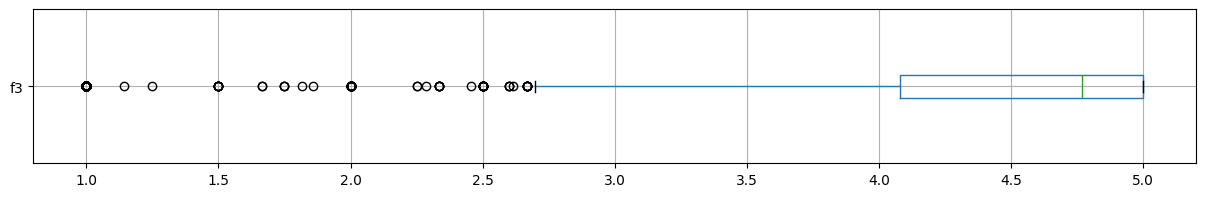

In [15]:
df.boxplot('f3', vert=False, figsize=(15, 2))
plt.show();

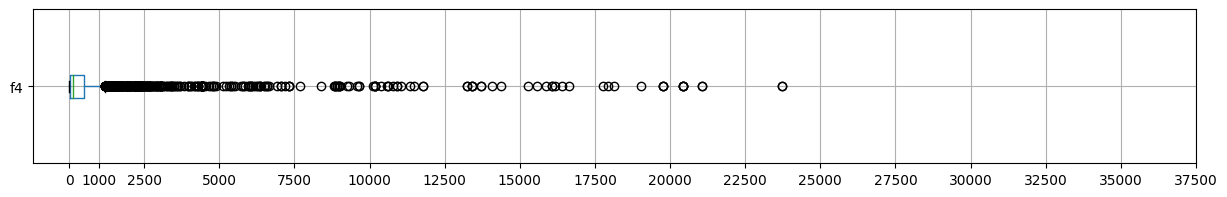

In [16]:
df.boxplot('f4', vert=False, figsize=(15, 2))
plt.xticks(np.append(np.arange(0, 40000, 2500), 1000))
plt.show();

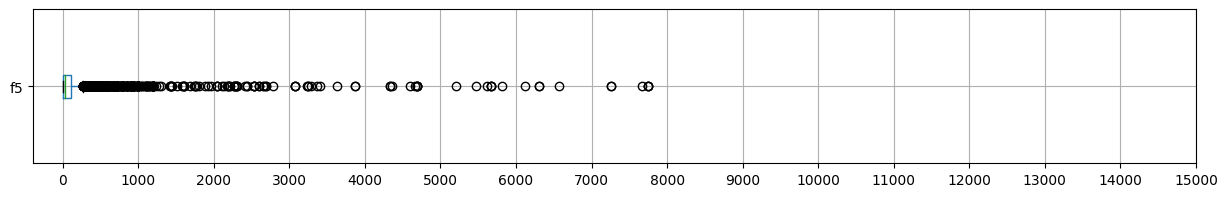

In [17]:
df.boxplot('f5', vert=False, figsize=(15, 2))
plt.xticks(np.arange(0, 16000, 1000))
plt.show();

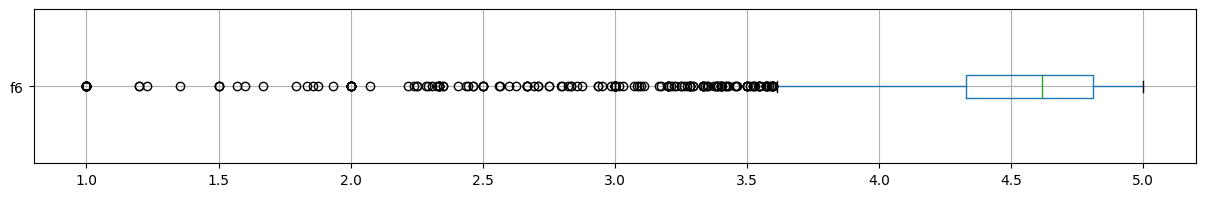

In [18]:
df.boxplot('f6', vert=False, figsize=(15, 2))
plt.show();

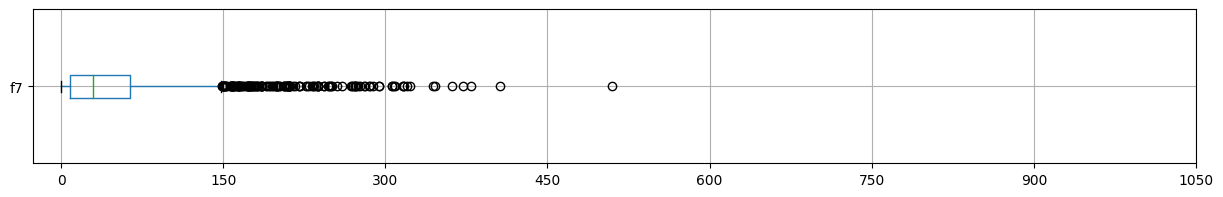

In [19]:
df.boxplot('f7', vert=False, figsize=(15, 2))
plt.xticks(np.arange(0, 1200, 150))
plt.show();

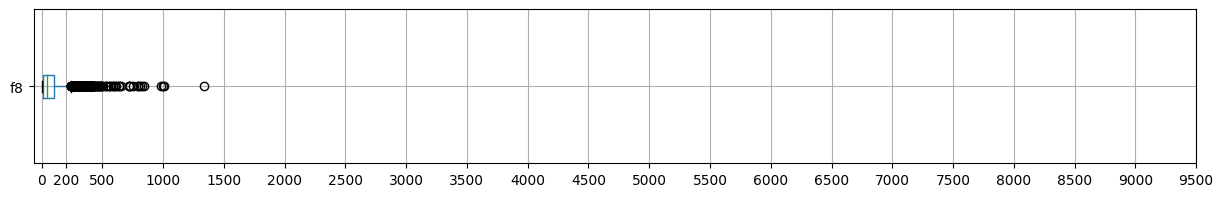

In [20]:
df.boxplot('f8', vert=False, figsize=(15, 2))
plt.xticks(np.append(np.arange(0, 10000, 500), 200))
plt.show();

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

In [22]:
X = df[['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [42]:
model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.7757731958762887

In [43]:
model = CatBoostClassifier(learning_rate=0.007, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(X_test, y_test)

0:	learn: 0.6907339	total: 57.3ms	remaining: 57.3s
1:	learn: 0.6884227	total: 64.7ms	remaining: 32.3s
2:	learn: 0.6864211	total: 71ms	remaining: 23.6s
3:	learn: 0.6840841	total: 77.9ms	remaining: 19.4s
4:	learn: 0.6818833	total: 84.1ms	remaining: 16.7s
5:	learn: 0.6797118	total: 90.2ms	remaining: 14.9s
6:	learn: 0.6775723	total: 96.9ms	remaining: 13.7s
7:	learn: 0.6754073	total: 102ms	remaining: 12.7s
8:	learn: 0.6732708	total: 109ms	remaining: 12s
9:	learn: 0.6713895	total: 114ms	remaining: 11.3s
10:	learn: 0.6693388	total: 119ms	remaining: 10.7s
11:	learn: 0.6671535	total: 124ms	remaining: 10.2s
12:	learn: 0.6651583	total: 127ms	remaining: 9.66s
13:	learn: 0.6633465	total: 130ms	remaining: 9.19s
14:	learn: 0.6616027	total: 133ms	remaining: 8.72s
15:	learn: 0.6597203	total: 135ms	remaining: 8.3s
16:	learn: 0.6578256	total: 138ms	remaining: 7.96s
17:	learn: 0.6560786	total: 140ms	remaining: 7.65s
18:	learn: 0.6542627	total: 143ms	remaining: 7.36s
19:	learn: 0.6526078	total: 145ms	remai

161:	learn: 0.5320374	total: 441ms	remaining: 2.28s
162:	learn: 0.5315587	total: 445ms	remaining: 2.28s
163:	learn: 0.5311717	total: 447ms	remaining: 2.28s
164:	learn: 0.5306864	total: 450ms	remaining: 2.27s
165:	learn: 0.5301319	total: 452ms	remaining: 2.27s
166:	learn: 0.5297154	total: 455ms	remaining: 2.27s
167:	learn: 0.5294076	total: 457ms	remaining: 2.26s
168:	learn: 0.5288988	total: 459ms	remaining: 2.26s
169:	learn: 0.5283923	total: 462ms	remaining: 2.25s
170:	learn: 0.5280564	total: 464ms	remaining: 2.25s
171:	learn: 0.5276555	total: 466ms	remaining: 2.24s
172:	learn: 0.5273287	total: 469ms	remaining: 2.24s
173:	learn: 0.5269915	total: 471ms	remaining: 2.24s
174:	learn: 0.5266955	total: 473ms	remaining: 2.23s
175:	learn: 0.5263709	total: 476ms	remaining: 2.23s
176:	learn: 0.5260027	total: 478ms	remaining: 2.22s
177:	learn: 0.5257606	total: 481ms	remaining: 2.22s
178:	learn: 0.5254630	total: 483ms	remaining: 2.22s
179:	learn: 0.5251925	total: 488ms	remaining: 2.22s
180:	learn: 

341:	learn: 0.4869116	total: 829ms	remaining: 1.59s
342:	learn: 0.4867291	total: 832ms	remaining: 1.59s
343:	learn: 0.4865285	total: 833ms	remaining: 1.59s
344:	learn: 0.4862367	total: 836ms	remaining: 1.59s
345:	learn: 0.4860551	total: 838ms	remaining: 1.58s
346:	learn: 0.4857930	total: 840ms	remaining: 1.58s
347:	learn: 0.4856941	total: 843ms	remaining: 1.58s
348:	learn: 0.4855161	total: 845ms	remaining: 1.58s
349:	learn: 0.4853024	total: 848ms	remaining: 1.57s
350:	learn: 0.4851721	total: 851ms	remaining: 1.57s
351:	learn: 0.4849462	total: 853ms	remaining: 1.57s
352:	learn: 0.4848004	total: 855ms	remaining: 1.57s
353:	learn: 0.4847354	total: 857ms	remaining: 1.56s
354:	learn: 0.4845166	total: 861ms	remaining: 1.56s
355:	learn: 0.4843926	total: 863ms	remaining: 1.56s
356:	learn: 0.4842789	total: 865ms	remaining: 1.56s
357:	learn: 0.4840960	total: 867ms	remaining: 1.55s
358:	learn: 0.4839486	total: 869ms	remaining: 1.55s
359:	learn: 0.4838312	total: 871ms	remaining: 1.55s
360:	learn: 

519:	learn: 0.4623124	total: 1.21s	remaining: 1.12s
520:	learn: 0.4621630	total: 1.21s	remaining: 1.12s
521:	learn: 0.4620384	total: 1.22s	remaining: 1.11s
522:	learn: 0.4619709	total: 1.22s	remaining: 1.11s
523:	learn: 0.4618480	total: 1.22s	remaining: 1.11s
524:	learn: 0.4618181	total: 1.22s	remaining: 1.11s
525:	learn: 0.4617433	total: 1.23s	remaining: 1.1s
526:	learn: 0.4615909	total: 1.23s	remaining: 1.1s
527:	learn: 0.4614980	total: 1.23s	remaining: 1.1s
528:	learn: 0.4614011	total: 1.24s	remaining: 1.1s
529:	learn: 0.4612788	total: 1.24s	remaining: 1.1s
530:	learn: 0.4612039	total: 1.24s	remaining: 1.09s
531:	learn: 0.4611044	total: 1.24s	remaining: 1.09s
532:	learn: 0.4610059	total: 1.25s	remaining: 1.09s
533:	learn: 0.4608112	total: 1.25s	remaining: 1.09s
534:	learn: 0.4606797	total: 1.25s	remaining: 1.08s
535:	learn: 0.4605444	total: 1.25s	remaining: 1.08s
536:	learn: 0.4604003	total: 1.25s	remaining: 1.08s
537:	learn: 0.4602374	total: 1.25s	remaining: 1.08s
538:	learn: 0.460

696:	learn: 0.4431247	total: 1.59s	remaining: 693ms
697:	learn: 0.4430330	total: 1.6s	remaining: 692ms
698:	learn: 0.4429305	total: 1.6s	remaining: 689ms
699:	learn: 0.4428015	total: 1.6s	remaining: 687ms
700:	learn: 0.4426901	total: 1.6s	remaining: 685ms
701:	learn: 0.4426146	total: 1.61s	remaining: 682ms
702:	learn: 0.4424639	total: 1.61s	remaining: 680ms
703:	learn: 0.4424314	total: 1.61s	remaining: 678ms
704:	learn: 0.4422691	total: 1.61s	remaining: 675ms
705:	learn: 0.4421576	total: 1.61s	remaining: 673ms
706:	learn: 0.4420828	total: 1.62s	remaining: 671ms
707:	learn: 0.4420156	total: 1.62s	remaining: 669ms
708:	learn: 0.4419035	total: 1.62s	remaining: 666ms
709:	learn: 0.4418636	total: 1.63s	remaining: 664ms
710:	learn: 0.4418254	total: 1.63s	remaining: 662ms
711:	learn: 0.4417419	total: 1.63s	remaining: 660ms
712:	learn: 0.4416768	total: 1.63s	remaining: 658ms
713:	learn: 0.4416068	total: 1.64s	remaining: 656ms
714:	learn: 0.4414989	total: 1.64s	remaining: 654ms
715:	learn: 0.44

876:	learn: 0.4256282	total: 1.98s	remaining: 278ms
877:	learn: 0.4254986	total: 1.99s	remaining: 276ms
878:	learn: 0.4254240	total: 1.99s	remaining: 274ms
879:	learn: 0.4253549	total: 1.99s	remaining: 271ms
880:	learn: 0.4252486	total: 1.99s	remaining: 269ms
881:	learn: 0.4251665	total: 1.99s	remaining: 267ms
882:	learn: 0.4250330	total: 2s	remaining: 265ms
883:	learn: 0.4249819	total: 2s	remaining: 262ms
884:	learn: 0.4249112	total: 2s	remaining: 260ms
885:	learn: 0.4248153	total: 2s	remaining: 258ms
886:	learn: 0.4247639	total: 2.01s	remaining: 256ms
887:	learn: 0.4246280	total: 2.01s	remaining: 253ms
888:	learn: 0.4245150	total: 2.01s	remaining: 251ms
889:	learn: 0.4244349	total: 2.01s	remaining: 249ms
890:	learn: 0.4243499	total: 2.02s	remaining: 247ms
891:	learn: 0.4242640	total: 2.02s	remaining: 244ms
892:	learn: 0.4241413	total: 2.02s	remaining: 242ms
893:	learn: 0.4240464	total: 2.02s	remaining: 240ms
894:	learn: 0.4238868	total: 2.02s	remaining: 238ms
895:	learn: 0.4238018	to

0.8105670103092784

In [44]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.7860824742268041

In [45]:
model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train, y_train)
pred = model.predict(X_test)
model.score(X_test, y_test)

0.770618556701031

In [46]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)
pred = model.predict(X_test)
model.score(X_test, y_test)

0.7757731958762887

In [47]:
model = LogisticRegression(n_jobs=10)
model.fit(X_train, y_train)
pred = model.predict(X_test)
model.score(X_test, y_test)

0.7783505154639175